# Principal Component Analisis


## 1 - Packages ##

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

## 2 - Overview of the Problem set ##

**Problem Statement**: we will reduce image dimensionality. It represented as array with dimension (1280, 960).

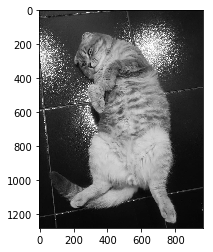

In [0]:
img = Image.open('cat2.jpeg')
img = img.convert('L', colors=256)
img = np.array(img, dtype=np.uint8)
imgplot = plt.imshow(img, cmap='gray')
plt.show()

In [0]:
print('Shape of image:', img.shape)

Shape of image: (1280, 960)


Firstly check the performance of PCA on simple synthetic dataset:

In [3]:
X = np.asarray([[12, 15, 20, 24, 27, 30, 63, 8, 67, 43, 11, 15, 67], 
                [34, 31, 29, 88, 76, 80, 89, 53, 48, 66, 45, 50, 85], 
                [45, 50, 43, 60, 65, 59, 89, 53, 43, 31, 33, 40, 80]]).T
print('Shape of input data:', X.shape)

Shape of input data: (13, 3)


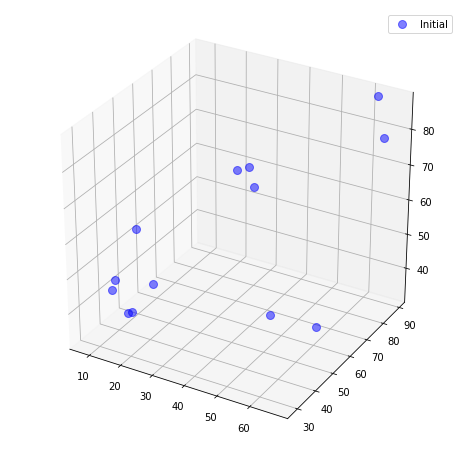

In [0]:
#Visualization

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(X.T[0,:], X.T[1,:], X.T[2,:], 'o', markersize=8, color='blue', alpha=0.5, label='Initial')

ax.legend(loc='upper right')

plt.show()

## 3 -  Principal Component Analisis. General Architecture
**Mathematics of the algorithm**:

Principal Component Analysis (PCA) is a linear transformation technique. 

Steps:
- Standardize the data;
- Get the Eigenvectors and Eigenvalues of covariance matrix;
- Choose the $k$ eigenvectors that correspond to the $k$ largest eigenvalues; $k$ = dimensionality of the new feature subspace $(k≤$n_features);
- Construct the projection matrix $W$ from the selected $k$ eigenvectors;
- Transform $X$ via $W$ to obtain a $k$-dimensional feature subspace $Y$.

### 3.1 -  Eigendecomposition: Computing Eigenvectors and Eigenvalues, 

**Standardizing the data**
$$z = \frac{x - \mu}{\sigma}\tag{1}$$

In [0]:
def normalize(X):

    X_norm = np.array(X)
    mean = np.mean(X_norm, axis=0)
    std = np.std(X_norm, axis=0)
    X_norm = (X_norm - mean)/std
    norm_parameters = np.vstack((mean, std))

    return X_norm, norm_parameters

In [5]:
norm_test, norm_pars_test = normalize(X)
print('Normalized:')
print(norm_test[0])
print('Parameters:')
print(norm_pars_test)

Normalized:
[-0.89985013 -1.19521931 -0.49137306]
Parameters:
[[30.92307692 59.53846154 53.15384615]
 [21.02914292 21.36717607 16.59400334]]


**Covariance Matrix**

The classic approach to PCA is to perform the eigendecomposition on the covariance matrix $Σ$, which is a $n_{features}×n_{features}$ matrix where each element represents the covariance between two features.

We can summarize the calculation of the covariance matrix via the following matrix equation:
$$\Sigma_{ij} = \frac{1}{N} \sum_{n=1}^{N} (x(n)_i – \mu_i)(x(n)_j – \mu_j)\tag{2}$$
where $\bar{x}$ is the mean vector ${\bar{x}} = \sum\limits_{k=1}^n x_{i}$.
The mean vector is a $n_{features}$-dimensional vector where each value in this vector represents the sample mean of a feature column in the dataset.


**Correlation Matrix**

A correlation matrix is used if the variances of individual variates differ much, or if the units of measurement of the individual variates differ.

$$\Sigma_{ij} = \frac{x_{ij}}{\sqrt{x_{ii}x_{jj}}}\tag{3}$$


**SVD**

While the eigendecomposition of the covariance or correlation matrix may be more intuitiuve, most PCA implementations perform a Singular Vector Decomposition (SVD) to improve the computational efficiency. 

To perform SVD in the right way we need to transpose the input matrix, so $X^T$ will have dimension $n_{features}×n_{samples}$. Let us assume that it is centered, i.e. column means have been subtracted and are now equal to zero.

Then the $n_{features}×n_{features}$ covariance matrix $C$ is given by $$C=X^TX/(n_{samples}−1).\tag{4}$$ It is a symmetric matrix and so it can be diagonalized: $$C = ULU^T,\tag{5}$$
where $U$ is a matrix of eigenvectors (each column is an eigenvector) and $L$ is a diagonal matrix with eigenvalues $λ_i$ in the decreasing order on the diagonal. The eigenvectors are called principal axes or principal directions of the data. Projections of the data on the principal axes are called principal components, also known as PC scores; these can be seen as new, transformed, variables. The $j$-th principal component is given by $j$-th column of $X^TV$. The coordinates of the $i$-th data point in the new PC space are given by the $i$-th row of $UX^T$.

If we now perform singular value decomposition of $X^T$, we obtain a decomposition
$$X^T=USV^T,\tag{6}$$
where $U$ is a unitary matrix and $S$ is the diagonal matrix of singular values $s_i$. From here one can easily see that $$C = USV^TVSU^T/(n_{samples}-1) = U \frac{S^2}{n_{samples}-1}U^T,\tag{7}$$
meaning that right singular vectors $U$ are principal directions and that singular values are related to the eigenvalues of covariance matrix via $λ_i=s^2_i/(n_{samples}−1)\tag{8}$.

In [0]:
class Eigendecomposition():
        
    def covariance(self, X):
        e_val, e_vect = np.linalg.eig(np.dot(X.T,X)/(X.shape[0]-1))
        return e_val, e_vect
    
    def correlation(self, X):
        
        cov = np.dot(X.T,X)/(X.shape[0]-1)
        corr = np.ones(cov.shape)
        
        for i in range(cov.shape[0]):
          for j in range(cov.shape[1]):
            corr[i,j] = cov[i,j]/((cov[i,i]*cov[j,j])**0.5)
            
        e_val, e_vect = np.linalg.eig(corr)
        
        return e_val, e_vect
    
    def svd(self, X):
        
        e_vect, S, VT = np.linalg.svd(X.T)
        e_val = S**2/(X.shape[0]-1)
        
        return e_val, e_vect
        

### 3.2-3.3 - Selecting Principal Components, Projection Onto the New Feature Space

The typical goal of a PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace, where the eigenvectors will form the axes. 

In order to decide which eigenvector(s) can be dropped without losing too much information for the construction of lower-dimensional subspace, we need to inspect the corresponding eigenvalues: the eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data - those are the ones can be dropped.

So now we need to implement following steps:
1. Compute eigenvectors $(e_1,e_2,...,e_d)$ and corresponding eigenvalues $(λ_1,λ_2,...,λ_d)$.
In order to do so, the common approach is to rank the eigenvalues from highest to lowest in order choose the top $k$ eigenvectors.
2. Sort the eigenvectors by decreasing eigenvalues and choose $k$ eigenvectors with the largest eigenvalues to form a $n_{features}×k$ dimensional matrix $W$ (where every row represents an eigenvector)
3. Use this $n_{features}×k$ eigenvector matrix to transform the samples onto the new subspace. This can be summarized by the mathematical equation: $$Y=X_{normalized}×W\tag{9}$$ (where $X_{normalized}$ is an normalized input matrix with shape $n_{samples}×n_{features}$, and $Y$ is the transformed $n_{samples}×k$-dimensional matrix of samples in the new subspace.)

4. To restore input matrix $X$ we should do next operation: $$X_{restored} = Y×W^T.\tag{10}$$ But don't forget that we worked with normalized data, so we also have to put it to the initial form back (use `norm_parameters` from `normalization` function).

In [0]:
class PCA():
    
    def __init__(self, X, n, eigendecomposition):
        self.X = X
        self.n = n
        self.eigendecomposition = eigendecomposition
        self.X_norm = None
        self.norm_params = None
        
        
    def transform(self):

        self.X_norm, self.norm_params = normalize(self.X)
        L, V = self.eigendecomposition(self.X_norm)
        matrix_w = V[:, np.argsort(L)[::-1][:self.n]]
        transformed = self.X_norm.dot(matrix_w)
        
        self.matrix_w = matrix_w
        self.transformed = transformed

        return transformed, matrix_w

        
    def restore(self):
        
        mean = self.norm_params[0,:]
        std = self.norm_params[1,:]
        return self.transformed.dot(self.matrix_w.T)*std+mean
        

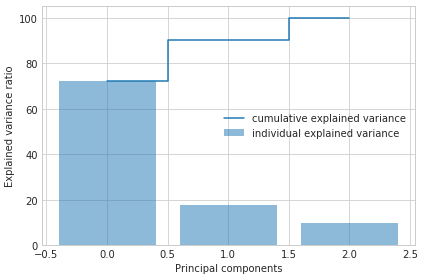

In [0]:
tot = sum(cov_vals)
var_exp = [(i / tot)*100 for i in sorted(cov_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(3), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(3), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
plt.show()

In [0]:
pca = PCA(X, 2, Eigendecomposition().correlation)

In [37]:
reduced_x, reduced_eigenvects = pca.transform()
print('Reduced input matrix:')
print(reduced_x[:5])

Reduced input matrix:
[[-1.49086967 -0.15159675]
 [-1.3199115  -0.10840709]
 [-1.50049321  0.29895991]
 [ 0.87097958 -0.90026658]
 [ 0.7886636  -0.71439948]]


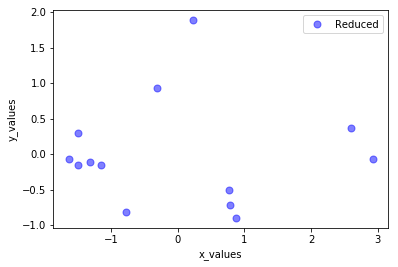

In [0]:
plt.plot(reduced_x.T[0,:], reduced_x.T[1,:], 'o', markersize=7, color='blue', alpha=0.5, label='Reduced')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()

plt.show()

Restore "original" values by the reduced:

In [0]:
new_x = pca.restore()
print('Restored:')
print(new_x[:5])

Restored:
[[11.51573657 41.48068378 39.47263947]
 [14.1995759  43.36459173 40.86399609]
 [19.41116905 38.09599585 36.27911059]
 [24.69623033 77.24494687 67.94674095]
 [27.07495924 74.84206341 65.85558128]]


Visualising of restored values:

<IPython.core.display.Javascript object>


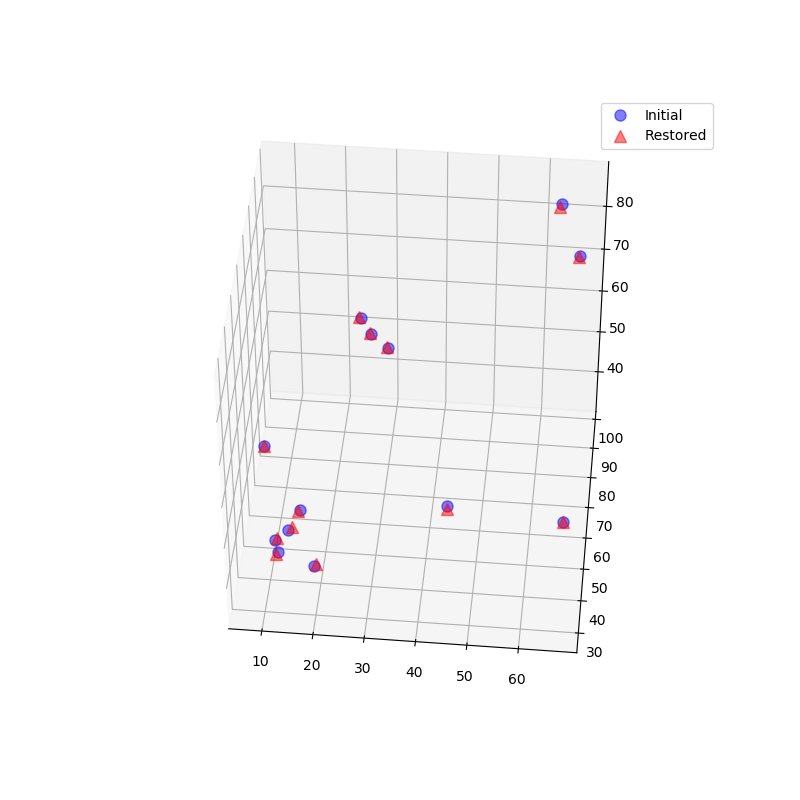

In [0]:
%matplotlib notebook
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(X.T[0,:], X.T[1,:], X.T[2,:], 'o', markersize=8, color='blue', alpha=0.5, label='Initial')
ax.plot(new_x.T[0,:], new_x.T[1,:], new_x.T[2,:], '^', markersize=8, alpha=0.5, color='red', label='Restored')

ax.legend(loc='upper right')


plt.show()

## 4 - Trying the Algorithm on Image

In [0]:
pca_img = PCA(img, 50, Eigendecomposition().covariance)

In [0]:
reduced_img, reduced_eigenvects_img = pca_img.transform()
print('Reduced array:')
print(reduced_img.shape)

Reduced array:
(1280, 200)


Restore the image and compare it with original:

In [0]:
restored_img = pca_img.restore()

Initial:


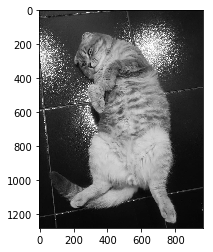

In [0]:
imgplot = plt.imshow(img, cmap='gray')
print('Initial:')
plt.show()


Restored:


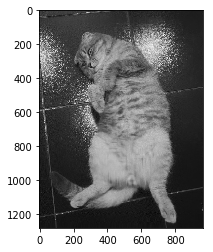

In [0]:
imgplot = plt.imshow(restored_img, cmap='gray')
print('Restored:')
plt.show()